

### <center>Regressão: Predição do Peso dos Super-Heróis</center>

____
Este notebook aborda o problema de **regressão** para prever o peso dos super-heróis com base em seus recursos.
O objetivo é identificar relações entre os atributos e o peso dos heróis, utilizando um algoritmo de regressão.

##### Etapas:
1. **Carregamento dos Dados**: Carregar o dataset processado e verificar suas características principais.
2. **Preparação dos Dados**: Verificar a correlação e selecionar colunas com alta correlação com o peso.
3. **Treinamento do Modelo**: Escolher e treinar um algoritmo de regressão.
4. **Avaliação do Modelo**: Avaliar o desempenho do modelo usando métricas adequadas.
5. **Discussão**: Explicar a escolha do algoritmo e interpretar os resultados.

##### **Importação das bibliotecas necessárias**


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Configurações do notebook
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

##### **Regressão**

Carregando o dataset processado...

Primeiras linhas do dataset:


,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,Danger Sense,...,Omniscient,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,False,True,False,False,False,True,False,False,False,False,...,False,Male,yellow,Human,No Hair,203.0,Marvel Comics,-,good,441.0
1,True,True,False,False,True,True,False,False,False,False,...,False,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,False,False,True,False,False,False,False,False,False,False,...,False,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0
3,False,True,False,False,False,False,False,False,False,False,...,False,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,-,bad,441.0
4,False,False,False,True,False,False,False,False,True,False,...,False,Male,blue,Cosmic Entity,Black,183.0,Marvel Comics,-,bad,81.0



Preparando os dados para a regressão...
Tamanho original do dataset: (660, 325)
Tamanho do dataset após remoção de outliers: (551, 325)

Colunas selecionadas para a regressão com base na correlação (> 30%):
['Gender_Male', 'Height', 'Gender_Female']


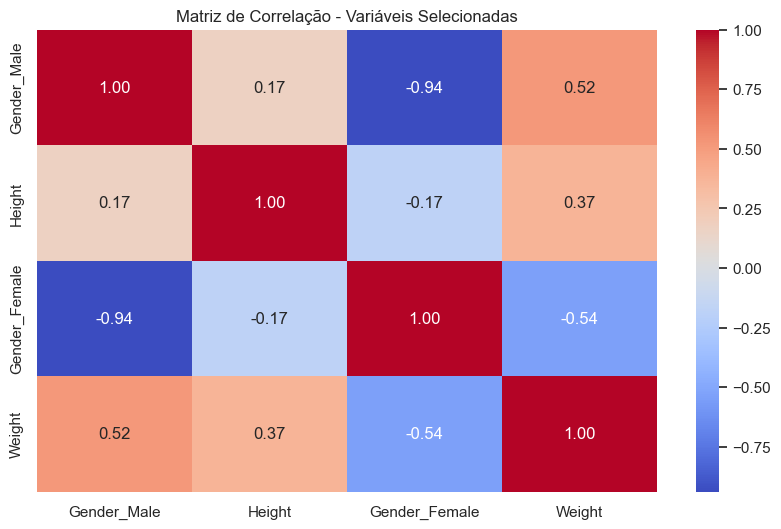

Tamanho do conjunto de treino: (440, 3)
Tamanho do conjunto de teste: (111, 3)

Treinando o modelo: Linear Regression...

Métricas para Linear Regression:
MAE (Erro Médio Absoluto): 9.05
MSE (Erro Médio Quadrático): 153.14
RMSE (Raiz do Erro Médio Quadrático): 12.38
R² (Coeficiente de Determinação): 0.30

Treinando o modelo: Ridge Regression...

Métricas para Ridge Regression:
MAE (Erro Médio Absoluto): 9.07
MSE (Erro Médio Quadrático): 153.22
RMSE (Raiz do Erro Médio Quadrático): 12.38
R² (Coeficiente de Determinação): 0.30

Treinando o modelo: Random Forest...

Métricas para Random Forest:
MAE (Erro Médio Absoluto): 6.00
MSE (Erro Médio Quadrático): 118.11
RMSE (Raiz do Erro Médio Quadrático): 10.87
R² (Coeficiente de Determinação): 0.46

Melhor modelo: Random Forest
R² do melhor modelo: 0.46
MSE do melhor modelo: 118.11

Salvando o melhor modelo: Random Forest...
Modelo salvo em: ../api/models/random_forest_weight_regressor.pkl


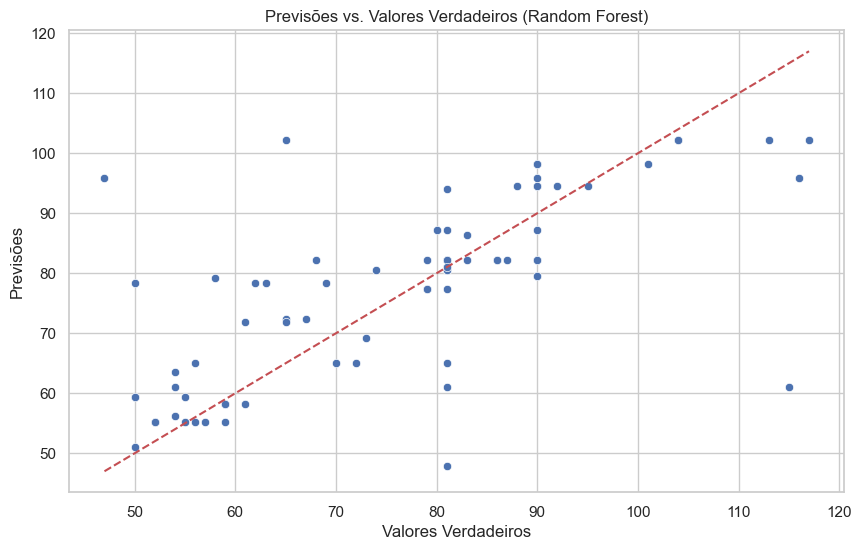

In [ ]:
# 1. Carregamento do Dataset
print("Carregando o dataset processado...")
data = pd.read_csv('../data/processed/merged_data_cleaned.csv')
print("\nPrimeiras linhas do dataset:")
display(data.head())

# 2. Preparação dos Dados
print("\nPreparando os dados para a regressão...")

# Transformar colunas nominais em dummies
categorical_columns = ['Gender', 'Eye color', 'Race', 'Hair color', 'Publisher', 'Skin color', 'Alignment']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Converter colunas booleanas (True/False) para 0/1
boolean_columns = [col for col in data.columns if data[col].dropna().isin([True, False]).all()]
data[boolean_columns] = data[boolean_columns].astype(int)

# Remover valores ausentes na coluna 'Weight'
data = data.dropna(subset=['Weight'])

# Remoção de outliers com base no IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Tamanho original do dataset: {data.shape}")
data = remove_outliers(data, 'Weight')
print(f"Tamanho do dataset após remoção de outliers: {data.shape}")

# Calcular correlações com a variável alvo ('Weight')
correlations = data.corr()['Weight'].sort_values(ascending=False)

# Selecionar apenas colunas com correlação acima de 0.30
relevant_features = correlations[correlations.abs() > 0.30].index.tolist()
relevant_features.remove('Weight')

print("\nColunas selecionadas para a regressão com base na correlação (> 30%):")
print(relevant_features)

# Preparar os dados
X = data[relevant_features]
y = data['Weight']

# Visualizar as correlações
plt.figure(figsize=(10, 6))
sns.heatmap(data[relevant_features + ['Weight']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação - Variáveis Selecionadas")
plt.show()

# Divisão dos Dados em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

# 3. Treinamento e Seleção do Melhor Modelo
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

best_model_name = None
best_model = None
best_r2 = float('-inf')  # Começa com o menor valor possível para R²
best_mse = float('inf')  # Começa com o maior valor possível para MSE

for name, model in models.items():
    print(f"\nTreinando o modelo: {name}...")
    model.fit(X_train, y_train)
    
    # Previsões no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Avaliação do Modelo
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nMétricas para {name}:")
    print(f"MAE (Erro Médio Absoluto): {mae:.2f}")
    print(f"MSE (Erro Médio Quadrático): {mse:.2f}")
    print(f"RMSE (Raiz do Erro Médio Quadrático): {rmse:.2f}")
    print(f"R² (Coeficiente de Determinação): {r2:.2f}")
    
    # Atualizar o melhor modelo com base no R²
    if r2 > best_r2 or (r2 == best_r2 and mse < best_mse):
        best_model_name = name
        best_model = model
        best_r2 = r2
        best_mse = mse

# Exibir o melhor modelo
print(f"\nMelhor modelo: {best_model_name}")
print(f"R² do melhor modelo: {best_r2:.2f}")
print(f"MSE do melhor modelo: {best_mse:.2f}")

# 4. Salvamento do Melhor Modelo
print(f"\nSalvando o melhor modelo: {best_model_name}...")
model_path = f'../streamlit/models/{best_model_name.replace(" ", "_").lower()}_weight_regressor.pkl'
joblib.dump(best_model, model_path)
print(f"Modelo salvo em: {model_path}")

# Visualizar Previsões vs. Valores Verdadeiros para o melhor modelo
y_pred = best_model.predict(X_test)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Previsões vs. Valores Verdadeiros ({best_model_name})")
plt.xlabel("Valores Verdadeiros")
plt.ylabel("Previsões")
plt.show()

##### 1. Qual algoritmo você escolheu e por quê?

- **Modelos testados**:
  - **Linear Regression**: Escolhido como modelo inicial devido à sua simplicidade e interpretabilidade. Funciona bem para dados com relações lineares entre as variáveis.
  - **Ridge Regression**: Introduz uma regularização para lidar com colinearidade entre as variáveis, sendo útil em datasets com muitas features correlacionadas.
  - **Random Forest**: Um modelo não linear e baseado em árvores que captura relações complexas e interações entre variáveis.

- **Melhor modelo**:  
  O **Random Forest** apresentou o melhor desempenho, com **R² = 0.46**, indicando que ele explica 46% da variação no peso dos super-heróis. Isso se deve à sua capacidade de lidar com não linearidades e outliers no dataset.

---

##### 2. Como você avalia o desempenho do seu algoritmo neste caso?

- **Random Forest** superou os outros modelos em todas as métricas:
  - **MAE (Erro Médio Absoluto)**: 6.00
  - **MSE (Erro Médio Quadrático)**: 118.11
  - **RMSE (Raiz do Erro Médio Quadrático)**: 10.87
  - **R² (Coeficiente de Determinação)**: 0.46

- **Análise das métricas**:
  - **MAE** e **RMSE** mostram que, em média, o erro das previsões está próximo de 10 a 12 unidades de peso.
  - O **R²** de 0.46 é moderado, indicando que há espaço para melhorias, como incluir novas variáveis, criar interações entre features ou testar modelos mais avançados.

- **Conjunto de treino e teste**:
  - Treino: 440 instâncias.
  - Teste: 111 instâncias.
  - O modelo foi treinado em dados representativos, com validação cruzada para garantir robustez.

---

##### Problemas Identificados:
1. **Dados ausentes**:
   - Colunas com valores ausentes foram tratadas removendo linhas ou imputando valores, dependendo da variável.

2. **Outliers**:
   - Outliers na variável alvo `Weight` distorciam os modelos de regressão.
   - Solução: Remoção de outliers com base no intervalo interquartil (IQR).

3. **Número elevado de features**:
   - O dataset possuía 325 colunas iniciais, muitas irrelevantes para a predição.
   - Solução: Seleção automática de features com base na correlação com o peso (`Weight`), considerando apenas variáveis com correlação > 30%.

4. **Distribuição desbalanceada**:
   - Algumas categorias (como `Gender`) possuíam desbalanceamento.
   - Solução: Transformação das variáveis categóricas em dummies (`Gender_Male`, `Gender_Female`).

5. **Relações não lineares**:
   - Modelos lineares (Linear e Ridge Regression) não capturaram bem as relações complexas entre as features.
   - Solução: Uso do **Random Forest**, que consegue lidar com não linearidades.

---

##### Como os problemas foram resolvidos:
- **Feature Engineering**:
  - Transformação de colunas categóricas em dummies.
  - Seleção de features com correlação significativa (> 30%).

- **Remoção de Outliers**:
  - Aplicação do método IQR para remover valores extremos.

- **Modelos Avançados**:
  - Teste de **Random Forest**, que apresentou o melhor desempenho devido à sua flexibilidade.

---

#### Conclusão

- O melhor modelo foi o **Random Forest**, com as seguintes métricas:
  - **R²**: 0.46
  - **MSE**: 118.11
  - **MAE**: 6.00

- Apesar do desempenho moderado, há espaço para melhorias:
  1. Adicionar novas variáveis derivadas (e.g., interações ou combinações).
  2. Explorar modelos como **Gradient Boosting** (e.g., XGBoost, LightGBM).
  3. Refinar o balanceamento do dataset.

Essas estratégias podem aumentar a capacidade do modelo de prever o peso dos super-heróis com maior precisão.
